#  **Lesson 13**

1.Introduction to Google Earth Engine

2.Google Earth Engine API

3.Example

4.GEE Related Research

# **3.Example**

**Initial libraries**


In [1]:
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

Installing geemap ...


In [2]:
import ee
import geemap

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Y7Uub3cnKI4KRtdk4-E6sTQxlm8GZqPRVScXe1LLOc8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhLRg6kecTP8M2iCFTl9EWssYs_DQcRSXw2dvoB1AKqwFtyEskrgjU

Successfully saved authorization token.


**Creat an interactive map**

In [4]:
Map = geemap.Map(center=[40, -100], zoom=4)
Map.add_basemap('HYBRID')
Map.addLayerControl()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

**ROI import**

In [5]:
roi = ee.Geometry.Polygon(
        [[[117.96378379556796,34.24723830187869],
[117.9863803014576,34.22440321201694],
[118.00897680338655,34.20156819708835],
[118.03491983986655,34.16590430596248],
[118.06086282537606,34.13024038378986],
[118.07509188192739,34.09108279338934],
[118.08932085909045,34.051925172477176],
[118.11442778783793,34.03007784549812],
[118.13953477187545,34.00823046001278],
[118.17342838447094,33.99643388354467],
[118.20732206122985,33.98463734290639],
[118.26256137880317,33.9874109340639],
[118.29017658429629,34.006839240272186],
[118.28766608504732,34.05331201052382],
[118.30566079019391,34.079306288568134],
[118.32365555110388,34.10530064760616],
[118.36298924807315,34.12954926144934],
[118.34206717698196,34.147211723161554],
[118.32114501155034,34.16487424757031],
[118.27511374760552,34.19187407429737],
[118.22071269768956,34.21125781297966],
[118.18891045802918,34.2216363221177],
[118.15710807940567,34.23201492739702],
[118.11610224678624,34.23824429983899],
[118.09225050019715,34.223366508769274],
[118.06839872541094,34.208488710453345],
[118.0424512196255,34.246547097651764],
[118.02152915479694,34.26556737892651],
[118.00060703389703,34.28458769917094],
[117.96713260267587,34.28251419811591],
[117.96378379556796,34.24723830187869]]])

roi_map = geemap.Map()
roi_map.add_basemap('HYBRID')
roi_map.centerObject(roi, 9)
roi_map.addLayer(roi,{},"roi")
roi_map.addLayerControl() # This line is not needed for ipyleaflet-based Map.
roi_map

Map(center=[34.1273487583888, 118.17102980772033], controls=(WidgetControl(options=['position', 'transparent_b…

# **Image collection filter**

In this case study,we can going to use USGS Landsat 8 Surface Reflectance Tier 1.

Let's filter the ImageCollection by roi ,date and cloud cover.

In [28]:
startDate = ee.Date("2013-1-1");
endDate  =ee.Date("2020-12-31");
images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate(startDate, endDate) \
    .filter(ee.Filter.lte("CLOUD_COVER", 10))


Let's filter the ImageCollection by cloud mask.

In [29]:
def cloud_mask(image):
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5
  snowBitMask = 1 << 4
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
  mask2 = qa.bitwiseAnd(cloudsBitMask).eq(0)
  mask3 = qa.bitwiseAnd(snowBitMask).eq(0)
  mask = mask1.add(mask2).add(mask3)
  return image.updateMask(mask.gte(1))
images = images.map(cloud_mask)

Get images properties


In [30]:
print(images.getInfo())

{'type': 'ImageCollection', 'bands': [], 'id': 'LANDSAT/LC08/C01/T1_SR', 'version': 1639397895472414, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['cfmask', 'cloud', 'fmask', 'global', 'l8sr', 'landsat', 'lc08', 'reflectance', 'sr', 'usgs'], 'visualization_1_bands': 'B5,B4,B3', 'thumb': 'https://mw1.google.com/ges/dd/images/LANDSAT_SR_thumb.png', 'visualization_1_max': '30000.0', 'description': '<p>This dataset is the atmospherically corrected\nsurface reflectance from  the Landsat 8 OLI/TIRS sensors.\nThese images contain 5 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and two thermal infrared (TIR) bands processed to orthorectified\nbrightness temperature</p><p>These data have been atmospherically corrected using\n<a href="https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_C1-LandSurfaceReflectanceCode-LAS

How many Landsat 8 images (2013-2019) are available for the study area?

In [31]:
print(images.size().getInfo())

61


Let's add the first image to the Map.

In [18]:
First_image_Map = geemap.Map()
First_image_Map.add_basemap('HYBRID')
First_image_Map.centerObject(roi, 9)

first_image = images.first()

vis_params = {
  'bands': ['B5', 'B4', 'B3'],
  'min': 0,
  'max': 6000,
  'gamma': 1.4,
}
First_image_Map.addLayer(first_image, vis_params, 'first image')
First_image_Map.addLayer(roi, {}, 'roi')
First_image_Map.addLayerControl()
First_image_Map

Map(center=[34.1273487583888, 118.17102980772033], controls=(WidgetControl(options=['position', 'transparent_b…

# **NDWI calculation and Water mask extraction**

Calculate NDWI




In [19]:
ndwi_map = geemap.Map()
ndwi_map.add_basemap('HYBRID')
ndwi_map.centerObject(roi, 9)

ndwi_image = first_image.normalizedDifference(['B3', 'B5'])


ndwi_map.addLayer(ndwi_image, {}, 'NDWI image')
ndwi_map.addLayer(roi, {}, 'roi')
ndwi_map.addLayerControl()
ndwi_map

Map(center=[34.1273487583888, 118.17102980772033], controls=(WidgetControl(options=['position', 'transparent_b…

Water mask extraction

In [20]:
WaterMask_map= geemap.Map()
WaterMask_map.add_basemap('HYBRID')
WaterMask_map.centerObject(roi, 9)

ndwi_threshold = 0
water_image = ndwi_image.gt(ndwi_threshold).selfMask()
WaterMask_map.addLayer(water_image, {'palette': 'blue'}, 'Water image')
WaterMask_map.addLayer(roi, {}, 'roi')
WaterMask_map

Map(center=[34.1273487583888, 118.17102980772033], controls=(WidgetControl(options=['position', 'transparent_b…

# **Area change analysis**

Define function to extract water

In [21]:
def extract_water(image):    
    ndwi_image = image.normalizedDifference(['B3', 'B5'])
    water_image = ndwi_image.gt(0.4)
    return water_image


Calculate area

In [26]:
cloud_threshold= 10
images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_threshold)

areaList = []

for year in range(2013,2020+1):
  print(year)
  yearly_images = images.filterDate(str(year)+"-01-01",str(year)+"-12-31")
  yearly_ndwi_images = yearly_images.map(extract_water)
  yearly_max_water_extent = yearly_ndwi_images.max()
  stats = yearly_max_water_extent.multiply(ee.Image.pixelArea()).reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = roi,
    scale = 30
  ).get('nd').getInfo()
  print(stats)
  areaList.append(stats/1000000)

print(areaList)


2013
264942589.031487
2014
277243140.66589
2015
277838590.2458312
2016
289419342.44145226
2017
285575494.12477213
2018
282988480.50452304
2019
276488194.3238356
2020
268348787.96292534
[264.942589031487, 277.24314066589, 277.8385902458312, 289.4193424414523, 285.57549412477215, 282.988480504523, 276.4881943238356, 268.34878796292537]


plot

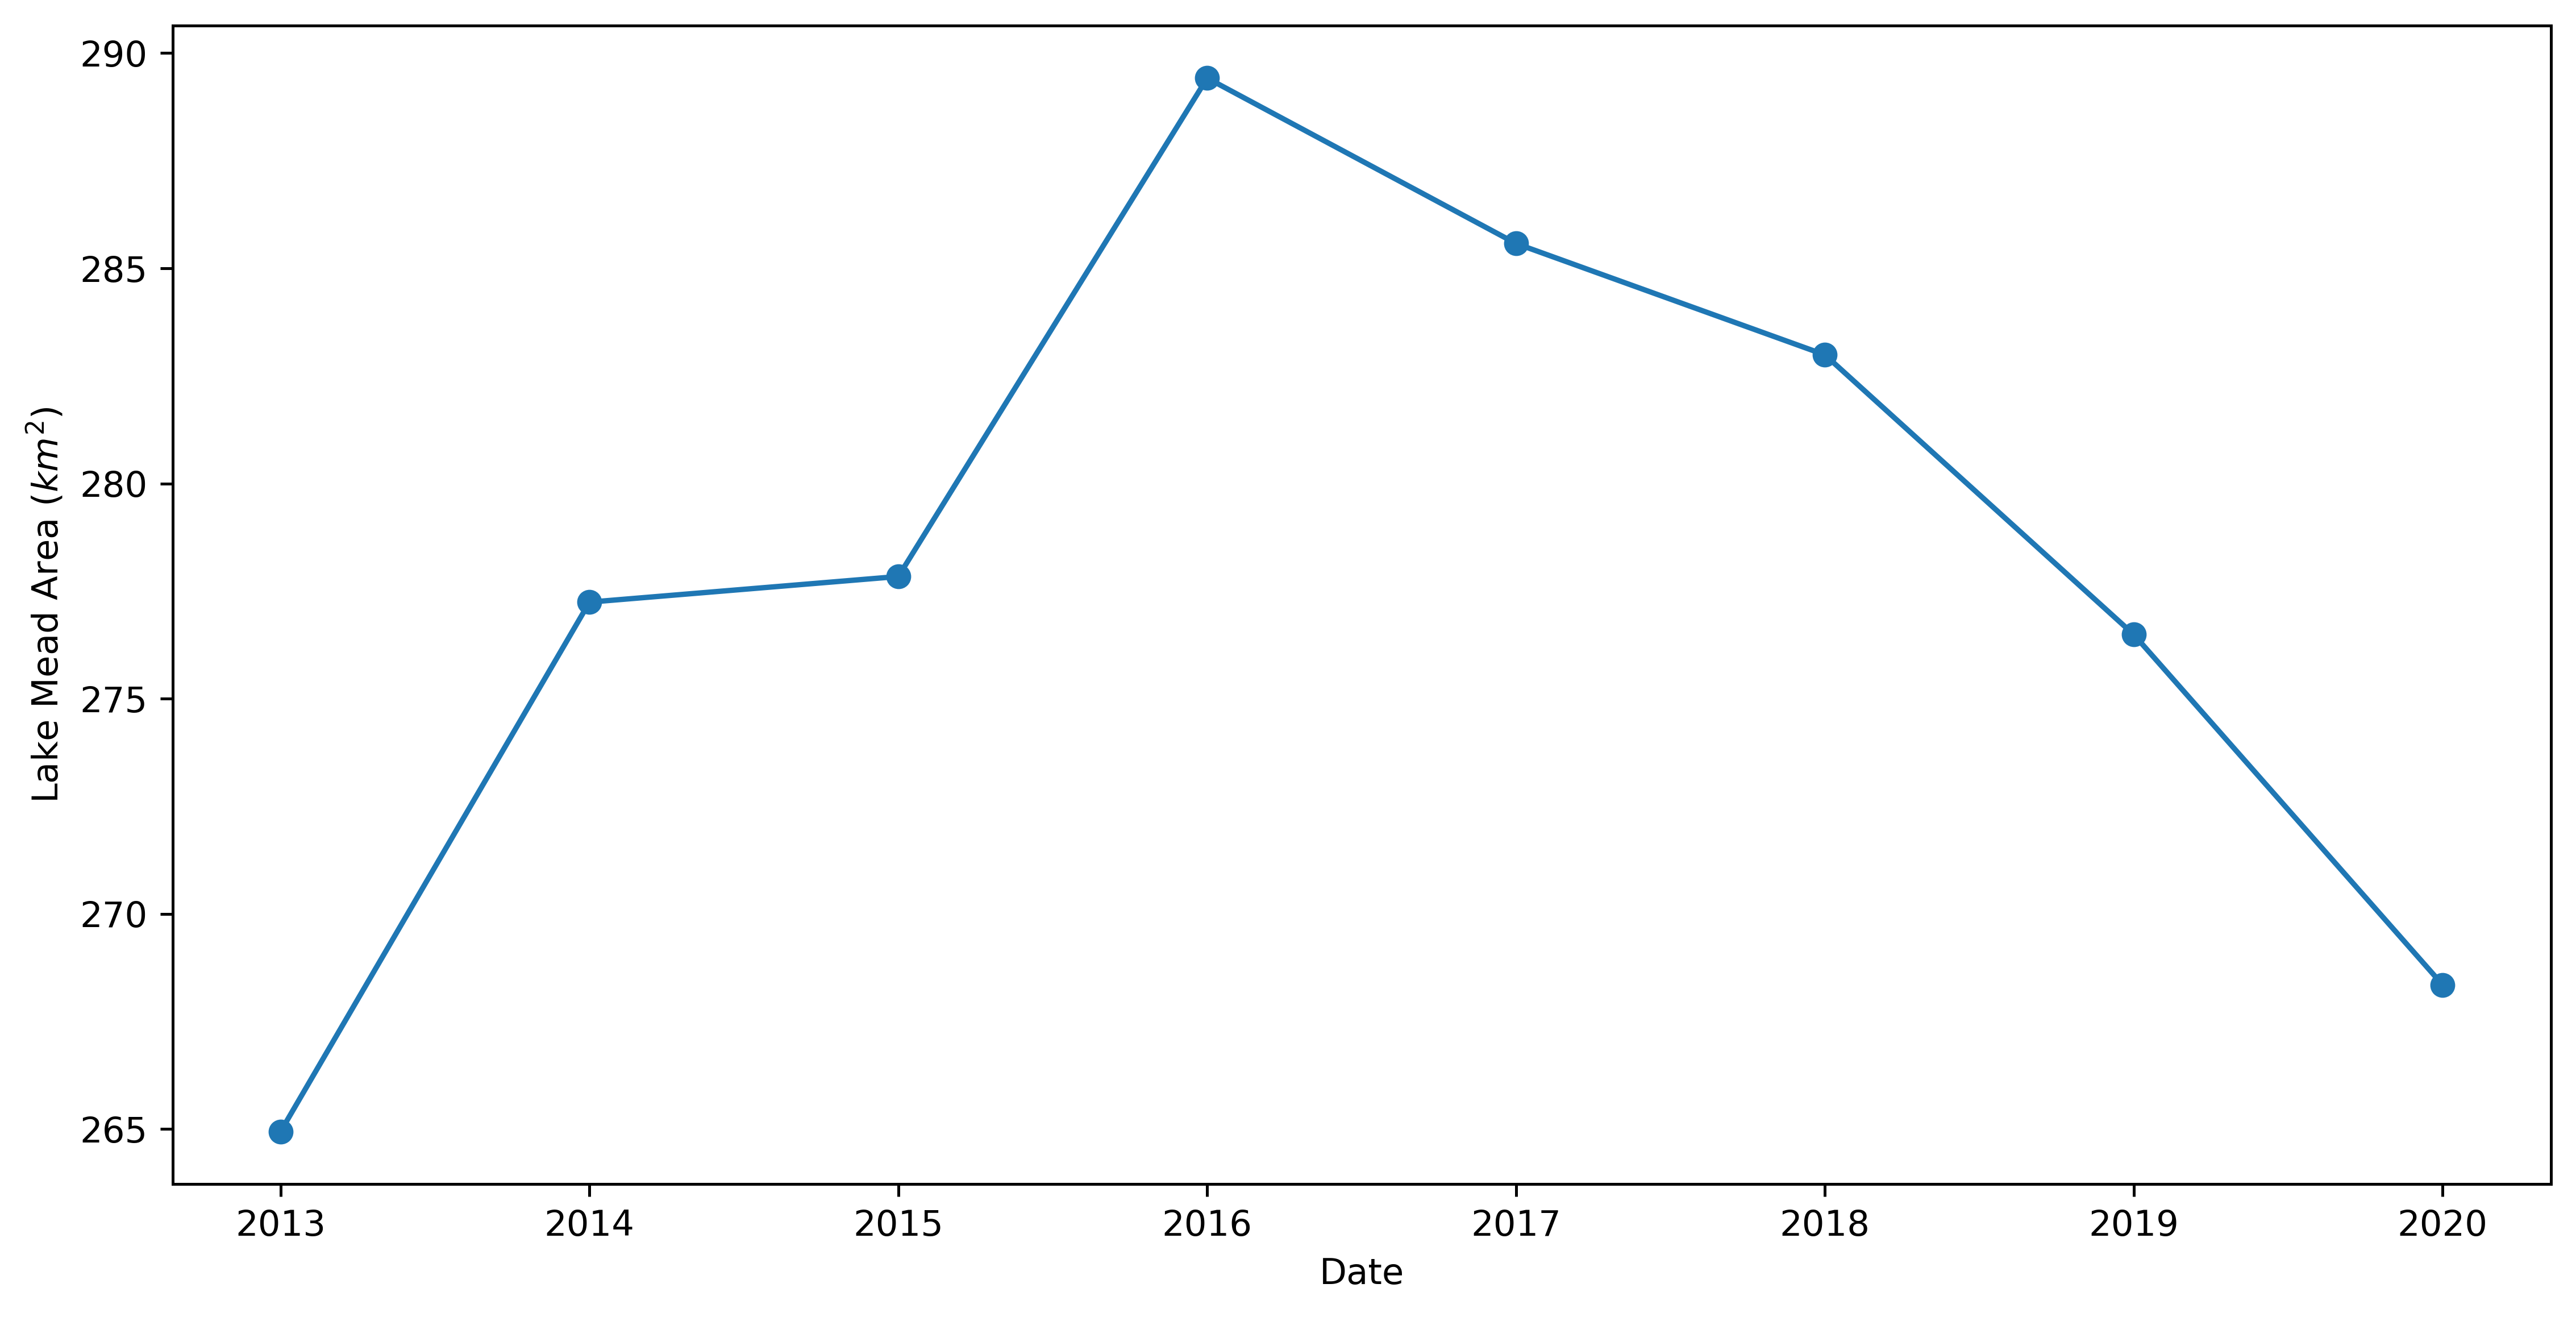

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt 

fig= plt.figure(figsize=(12,6),dpi=450)

x = range(2013,2020+1)

plt.plot(x, areaList, marker='o')
plt.xlabel('Date')
plt.ylabel('Lake Mead Area ($km^2$)')
plt.show()

# **Data export**

Export an image to Google Drive

In [ ]:
task = ee.batch.Export.image.toDrive(image=images.first(),region=roi,description='image_first',folder='gee_test',scale=30,crs='EPSG:4326')
task.start()

Inspect current exporting status

In [ ]:
task.status()